## Processing the Peturbseq Data with Seurat

We process data previously downloaded in `1.download-perturbseq.ipynb` using [SEURAT](https://github.com/satijalab/seurat).

> Stuart T, Butler A, Hoffman P, Hafemeister C, Papalexi E, III WMM, Hao Y, Stoeckius M, Smibert P, Satija R (2019). “Comprehensive Integration of Single-Cell Data.” Cell, 177, 1888-1902. doi: 10.1016/j.cell.2019.05.031, https://doi.org/10.1016/j.cell.2019.05.031.

We followed the standard Seurat tutorial for data quality control and normalization: https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html

In [1]:
options(repr.plot.width = 16, repr.plot.height = 10)
.libPaths()

[1] "/Users/gway/miniconda3/envs/perturbseq-processing/lib/R/library"

In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))

In [3]:
# Provide directory of 10X data
gse_id <- "GSE132080"
base_dir <- file.path("data", "perturbseq")
data_dir <- file.path(base_dir, gse_id)

processed_output_file <- file.path(base_dir, paste0(gse_id, "_processed_matrix.tsv.gz"))
processed_output_file

[1] "data/perturbseq/GSE132080_processed_matrix.tsv.gz"

In [4]:
# Initialize the Seurat object
perturbseq_data <- Seurat::Read10X(data.dir = data_dir)

perturbseq <- Seurat::CreateSeuratObject(
    counts = perturbseq_data,
    project = "crispri",
    min.cells = 3,
    min.features = 200
)

perturbseq

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
20275 features across 23633 samples within 1 assay 
Active assay: RNA (20275 features, 0 variable features)

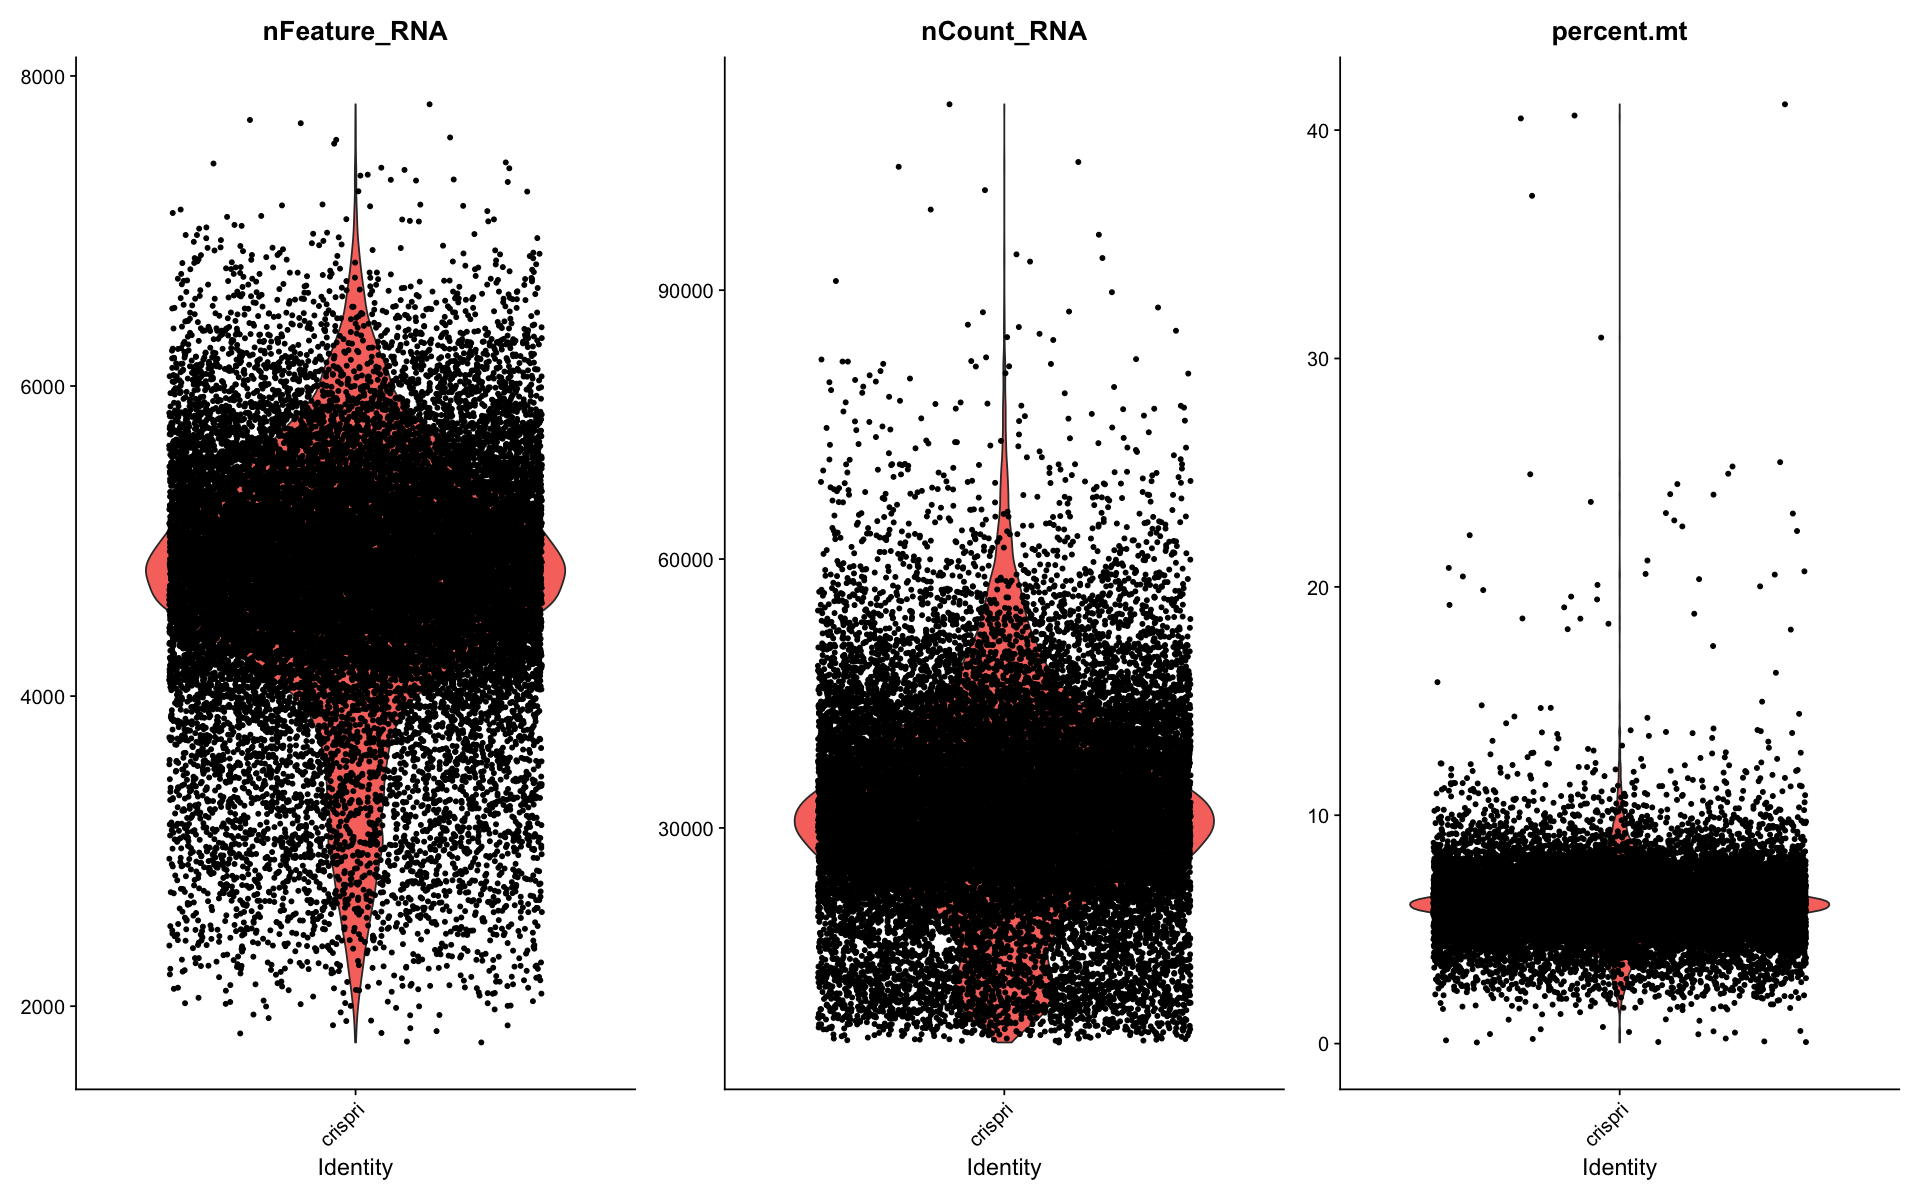

In [5]:
# Identify proportion of cells mapping to the mitochondrial genome
perturbseq[["percent.mt"]] <- Seurat::PercentageFeatureSet(perturbseq, pattern = "^MT-")

Seurat::VlnPlot(perturbseq, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

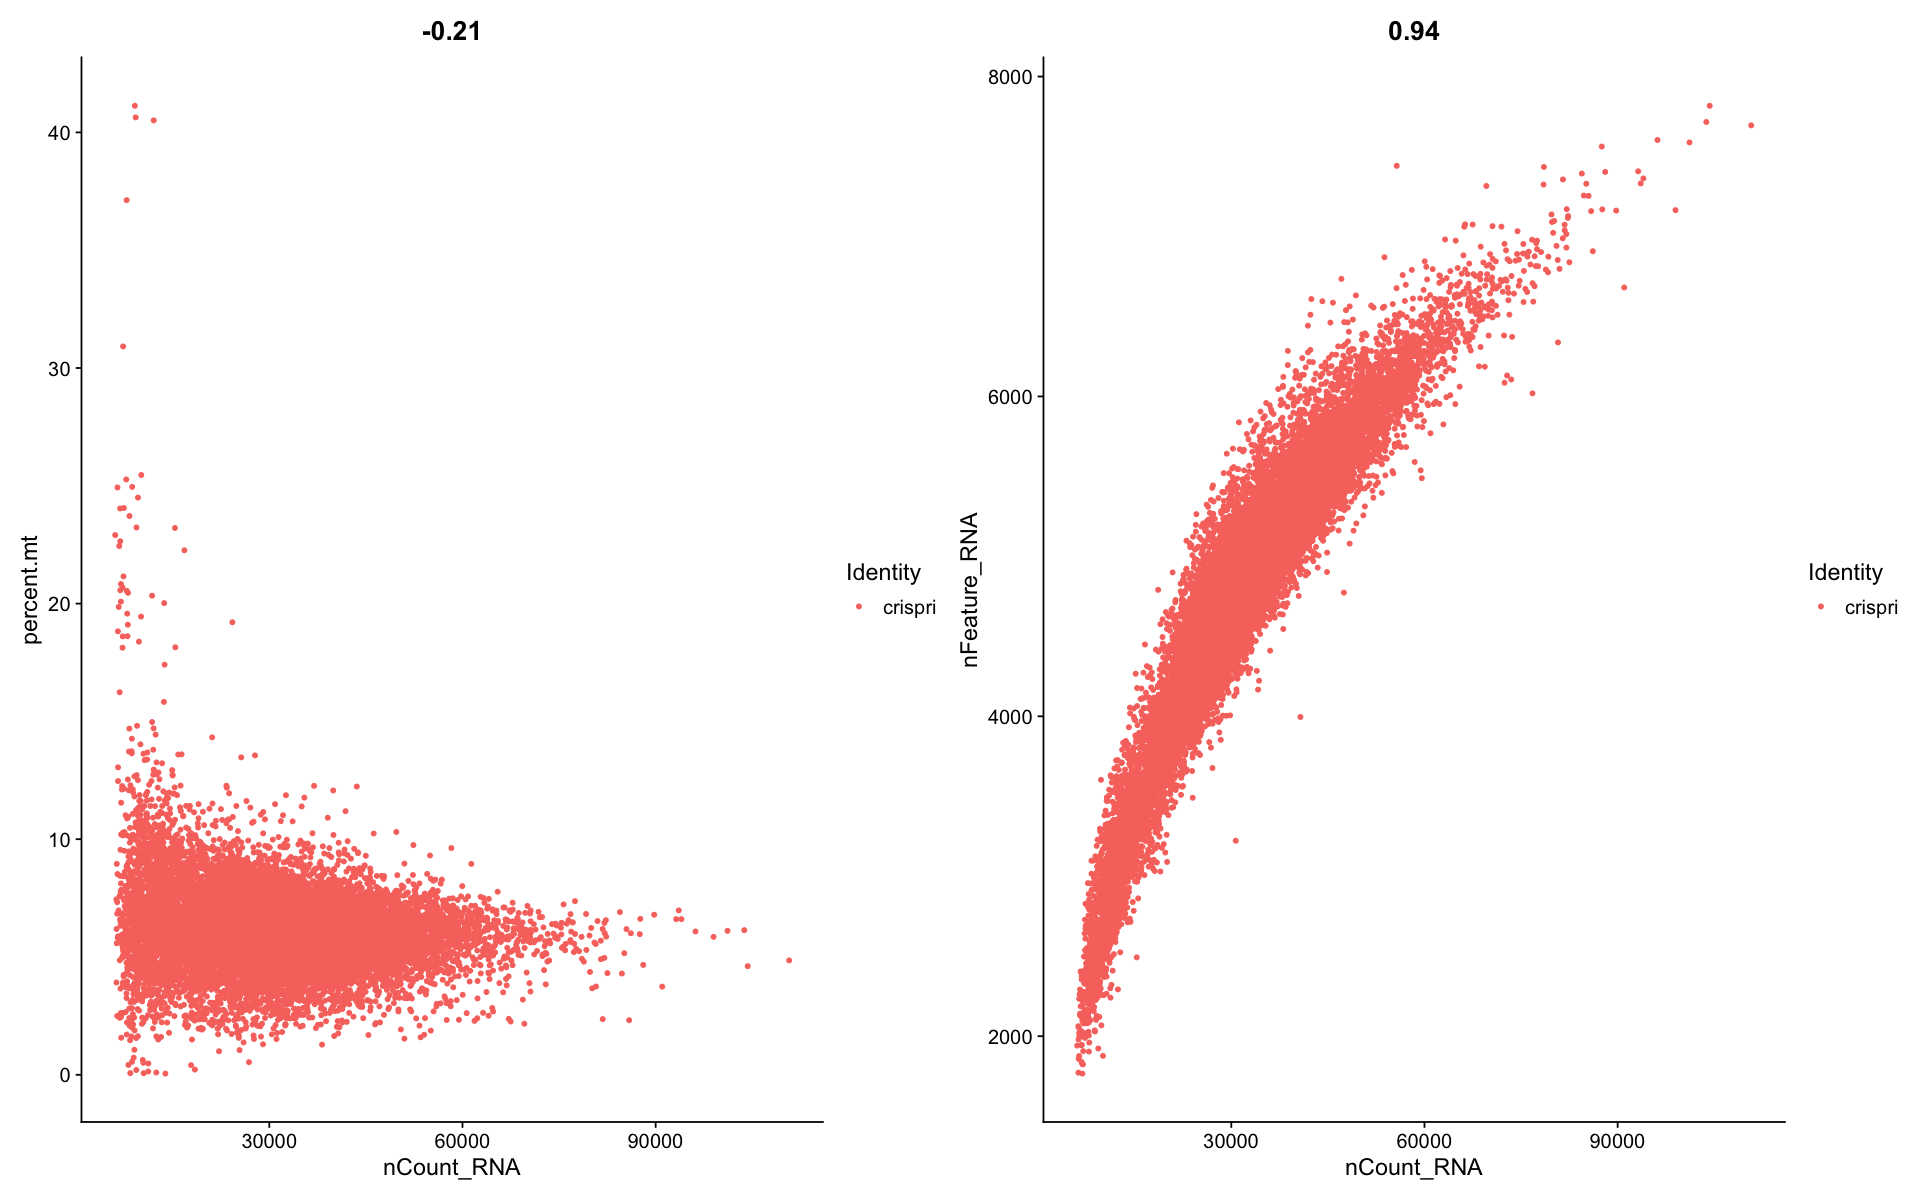

In [6]:
# Visualize relationships between counts
plot1 <- Seurat::FeatureScatter(perturbseq, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- Seurat::FeatureScatter(perturbseq, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [7]:
# Filter cells with too few and too much RNA, and cells that have outlier percentage of mito
perturbseq <- subset(
    perturbseq,
    subset = nFeature_RNA > 2000 & nFeature_RNA < 7000 & percent.mt < 15
)

In [8]:
# Normalize
perturbseq <- Seurat::NormalizeData(perturbseq, normalization.method = "LogNormalize", scale.factor = 10000)

# Z score scale data
all.genes <- rownames(perturbseq)
perturbseq <- ScaleData(perturbseq, features = all.genes)

# Find the top 1,000 most highly variable genes
perturbseq <- Seurat::FindVariableFeatures(perturbseq, selection.method = "vst", nfeatures = 1000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(perturbseq), 10)

top10

Centering and scaling data matrix



[1] "LTB"  "HBE1" "HBZ"  "VGF"  "CCL2" "DLK1" "ALB"  "IER3" "HBD"  "HBG2"

When using repel, set xnudge and ynudge to 0 for optimal results



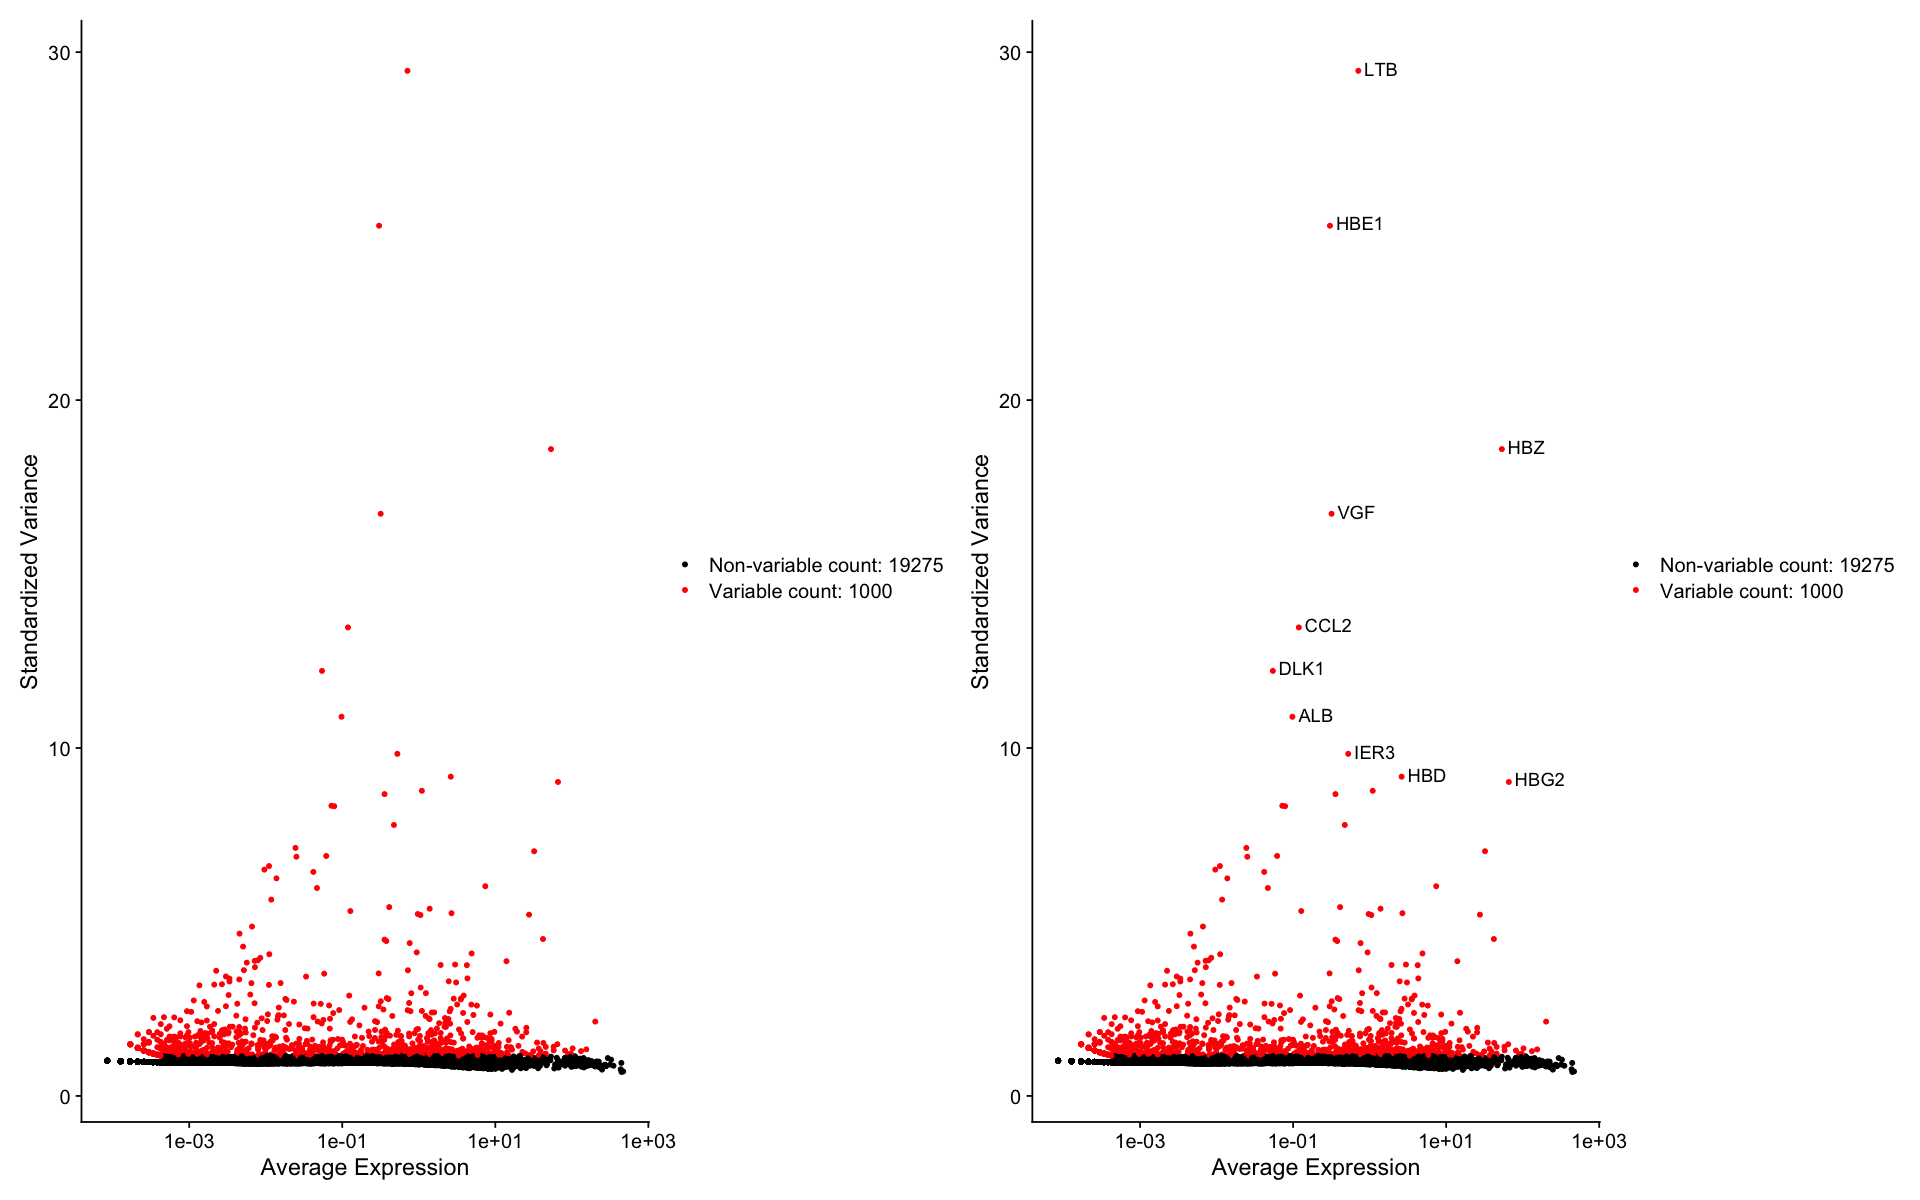

In [9]:
# Plot feature expression average and variance
plot1 <- VariableFeaturePlot(perturbseq)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

In [10]:
# Extract data
scaled_perturbseq_data <- GetAssayData(object = perturbseq, slot = "scale.data")
selected_features <- VariableFeatures(perturbseq)

scaled_perturbseq_data <- tibble::rownames_to_column(
    as.data.frame(scaled_perturbseq_data),
    var = "gene"
) %>% dplyr::filter(gene %in% selected_features)

dim(scaled_perturbseq_data)
head(scaled_perturbseq_data, 3)

[1]  1000 23538

,gene,AAACCTGAGAGTAATC-1,AAACCTGAGGGATCTG-1,AAACCTGAGGTCATCT-1,AAACCTGCAATGGAGC-1,AAACCTGCACCAGGCT-1,AAACCTGCACCATCCT-1,AAACCTGCACTTACGA-1,AAACCTGCAGTGGGAT-1,AAACCTGCATCGATTG-1,⋯,TTTGTCAGTAGCTTGT-3,TTTGTCAGTCTAGTGT-3,TTTGTCAGTCTCAACA-3,TTTGTCAGTTCCACGG-3,TTTGTCAGTTGGTGGA-3,TTTGTCAGTTTGACTG-3,TTTGTCAGTTTGTTGG-3,TTTGTCATCACAAACC-3,TTTGTCATCAGCATGT-3,TTTGTCATCTTAGAGC-3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,HES4,-0.82435490,-0.82435490,0.26444179,-0.82435490,-0.82435490,0.64772938,-0.82435490,-0.82435490,0.59668123,⋯,0.11647725,-0.82435490,0.25336794,0.10727593,-0.82435490,-0.06937033,1.76950785,1.05904509,-0.82435490,0.45810445
2,TNFRSF18,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,⋯,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004,-0.05538004
3,TNFRSF4,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,⋯,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934,-0.04323934


In [11]:
# Output to file
scaled_perturbseq_data %>% readr::write_tsv(processed_output_file)